## Agregação por distrito

Nesse notebook é feita a agregação dos dados por distritos do município

In [1]:
import geopandas as gpd
from shapely.geometry import LineString
from utils.save_shp import save_shp
from utils.load_csv import load_csv
from utils.load_shp import load_shp

In [2]:
df_final = load_csv("df_final.csv")

distritos = load_shp("distritos.shp")

In [3]:
df_final["lon"] = df_final["ponto_inicial"].apply(lambda x: eval(x)[0])
df_final["lat"] = df_final["ponto_inicial"].apply(lambda x: eval(x)[1])

In [4]:
gdf = gpd.GeoDataFrame(df_final, geometry=gpd.points_from_xy(df_final.lon, df_final.lat), crs="EPSG:4326")

In [5]:
gdf.head()

,id_onibus,distancia_percorrida,ponto_inicial,ponto_final,momento_inicial,momento_final,modelo,litro_diesel_km,emissao_no2,emissao_co2,eletrico,is_eletrico,lon,lat,geometry
0,71429,0.000684,"[-46.7605565, -23.6548535]","[np.float64(-46.7600795), np.float64(-23.65436...",2025-08-29 12:17:58+00:00,2025-08-29 12:18:06+00:00,Básico,0.53,0.000010,0.000024,NaN,True,-46.760556,-23.654854,POINT (-46.76056 -23.65485)
1,71429,0.003150,"[-46.7600795, -23.65436375]","[np.float64(-46.757994), np.float64(-23.652003...",2025-08-29 12:18:06+00:00,2025-08-29 12:19:01+00:00,Básico,0.53,0.000048,0.000111,NaN,False,-46.760080,-23.654364,POINT (-46.76008 -23.65436)
2,71429,0.000321,"[-46.757994, -23.65200325]","[np.float64(-46.75778675), np.float64(-23.6517...",2025-08-29 12:19:01+00:00,2025-08-29 12:19:39+00:00,Básico,0.53,0.000005,0.000011,NaN,False,-46.757994,-23.652003,POINT (-46.75799 -23.652)
3,71429,0.000000,"[-46.75778675, -23.6517585]","[np.float64(-46.75778675), np.float64(-23.6517...",2025-08-29 12:19:39+00:00,2025-08-29 12:19:39+00:00,Básico,0.53,0.000000,0.000000,NaN,True,-46.757787,-23.651758,POINT (-46.75779 -23.65176)
4,71429,0.000000,"[-46.75778675, -23.6517585]","[np.float64(-46.75778675), np.float64(-23.6517...",2025-08-29 12:19:39+00:00,2025-08-29 12:20:15+00:00,Básico,0.53,0.000000,0.000000,NaN,True,-46.757787,-23.651758,POINT (-46.75779 -23.65176)


In [6]:
dropar = gdf['id_onibus'].value_counts()[(gdf['id_onibus'].value_counts() == 1)].index

gdf = gdf[~gdf['id_onibus'].isin(dropar)].reset_index(drop=True)

In [7]:
trajetos = gdf.groupby("id_onibus")["geometry"].apply(lambda x: LineString(x.tolist()))
trajetos = gpd.GeoDataFrame(trajetos, geometry="geometry", crs="EPSG:4326").reset_index()

In [8]:
trajetos.head()

,id_onibus,geometry
0,3117,"LINESTRING (-46.52966 -23.6036, -46.52952 -23...."
1,5601,"LINESTRING (-46.5497 -23.60079, -46.54761 -23...."
2,7302,"LINESTRING (-46.77799 -23.69259, -46.77799 -23..."
3,7311,"LINESTRING (-46.74762 -23.67449, -46.74876 -23..."
4,10001,"LINESTRING (-46.7106 -23.48722, -46.71087 -23...."


In [9]:
agregados = gdf.groupby("id_onibus").agg({
    "emissao_co2": "sum",  
    "eletrico": "any"       
}).reset_index()

trajetos = trajetos.merge(agregados, on="id_onibus", how="left")

In [10]:
trajetos

,id_onibus,geometry,emissao_co2,eletrico
0,3117,"LINESTRING (-46.52966 -23.6036, -46.52952 -23....",0.001273,False
1,5601,"LINESTRING (-46.5497 -23.60079, -46.54761 -23....",0.000881,False
2,7302,"LINESTRING (-46.77799 -23.69259, -46.77799 -23...",0.000000,False
3,7311,"LINESTRING (-46.74762 -23.67449, -46.74876 -23...",0.021403,False
4,10001,"LINESTRING (-46.7106 -23.48722, -46.71087 -23....",0.000049,False
...,...,...,...,...
11271,86607,"LINESTRING (-46.69386 -23.56566, -46.69386 -23...",0.000366,False
11272,86608,"LINESTRING (-46.72817 -23.62348, -46.72858 -23...",0.000427,False
11273,86609,"LINESTRING (-46.69965 -23.58815, -46.69965 -23...",0.000628,False
11274,86610,"LINESTRING (-46.68746 -23.57617, -46.68746 -23...",0.000572,False


<Axes: >

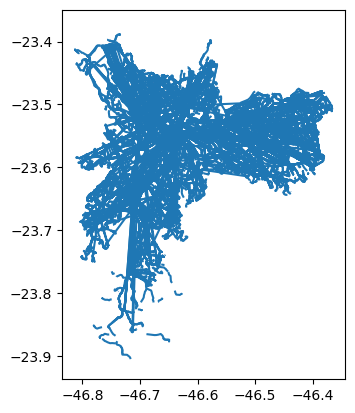

In [11]:
trajetos.plot()

In [12]:
trajetos = trajetos.to_crs(distritos.crs)

In [13]:
trajetos_distritos = gpd.sjoin(trajetos, distritos, how="inner", predicate="intersects")

trajetos_distritos

,id_onibus,geometry,emissao_co2,eletrico,index_right,cd_identif,cd_identi0,cd_distrit,nm_distrit,sg_distrit,tx_escala,sg_fonte_o,dt_criacao,dt_atualiz,cd_usuario,cd_tipo_di,qt_area_qu,qt_area_me
0,3117,"LINESTRING (343930.752 7388825.093, 343945.348...",0.001273,False,4,8583416.0,29.0,72,SAO LUCAS,SLU,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,9.674,9674427.42
0,3117,"LINESTRING (343930.752 7388825.093, 343945.348...",0.001273,False,25,8583420.0,32.0,76,SAPOPEMBA,SAP,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,13.633,13632901.77
1,5601,"LINESTRING (341883.006 7389114.065, 342096.844...",0.000881,False,4,8583416.0,29.0,72,SAO LUCAS,SLU,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,9.674,9674427.42
2,7302,"LINESTRING (318711.714 7378676.371, 318711.714...",0.000000,False,51,8583438.0,18.0,43,JARDIM ANGELA,JDA,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,36.364,36363863.45
3,7311,"LINESTRING (321784.966 7380719.185, 321669.078...",0.021403,False,51,8583438.0,18.0,43,JARDIM ANGELA,JDA,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,36.364,36363863.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11275,90999,"LINESTRING (345192.553 7387677.815, 347486.881...",0.062068,False,47,8583445.0,21.0,5,ARTUR ALVIM,AAL,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,6.506,6505750.23
11275,90999,"LINESTRING (345192.553 7387677.815, 347486.881...",0.062068,False,37,8583402.0,21.0,59,PENHA,PEN,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,11.429,11428502.95
11275,90999,"LINESTRING (345192.553 7387677.815, 347486.881...",0.062068,False,68,8583407.0,22.0,64,PONTE RASA,PRA,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,6.597,6596680.61
11275,90999,"LINESTRING (345192.553 7387677.815, 347486.881...",0.062068,False,30,8583458.0,21.0,18,CANGAIBA,CNG,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,13.746,13746396.83


In [14]:
gdf_overlay = gpd.overlay(trajetos, distritos, how="intersection")

gdf_overlay['distancia'] = gdf_overlay.geometry.length

gdf_overlay

,id_onibus,emissao_co2,eletrico,cd_identif,cd_identi0,cd_distrit,nm_distrit,sg_distrit,tx_escala,sg_fonte_o,dt_criacao,dt_atualiz,cd_usuario,cd_tipo_di,qt_area_qu,qt_area_me,geometry,distancia
0,3117,0.001273,False,8583416.0,29.0,72,SAO LUCAS,SLU,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,9.674,9674427.42,"MULTILINESTRING ((343930.752 7388825.093, 3439...",924.585139
1,3117,0.001273,False,8583420.0,32.0,76,SAPOPEMBA,SAP,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,13.633,13632901.77,"LINESTRING (344065.917 7389236.359, 344246.577...",589.844865
2,5601,0.000881,False,8583416.0,29.0,72,SAO LUCAS,SLU,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,9.674,9674427.42,"LINESTRING (341883.006 7389114.065, 342096.844...",1987.035047
3,7302,0.000000,False,8583438.0,18.0,43,JARDIM ANGELA,JDA,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,36.364,36363863.45,LINESTRING EMPTY,0.000000
4,7311,0.021403,False,8583484.0,18.0,46,JARDIM SAO LUIS,JDS,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,26.048,26047652.36,"MULTILINESTRING ((321784.966 7380719.185, 3216...",21250.898982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16749,90999,0.062068,False,8583407.0,22.0,64,PONTE RASA,PRA,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,6.597,6596680.61,"MULTILINESTRING ((347205.273 7397997.13, 34747...",7169.155148
16750,90999,0.062068,False,8583417.0,30.0,73,SAO MATEUS,SMT,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,12.800,12800219.28,"MULTILINESTRING ((347536.885 7391603.883, 3475...",10844.755888
16751,90999,0.062068,False,8583429.0,26.0,85,VILA FORMOSA,VFO,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,7.473,7473222.27,"MULTILINESTRING ((342263.936 7394160.687, 3422...",3191.566584
16752,90999,0.062068,False,8583437.0,29.0,93,VILA PRUDENTE,VPR,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,9.525,9525461.96,"MULTILINESTRING ((339584.664 7391452.014, 3390...",4695.977112


In [15]:
gdf_distrito = gdf_overlay.groupby('nm_distrit').agg({
    'distancia':'sum',
    "emissao_co2": 'sum',
    "eletrico": 'any'
}).reset_index()

In [16]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

distritos = distritos.merge(gdf_distrito, on='nm_distrit', how='left')
distritos_final = distritos.fillna(0)

In [17]:
warnings.filterwarnings("ignore", category = RuntimeWarning)
warnings.filterwarnings("ignore", category = UserWarning)

save_shp(distritos_final, "distritos_final.shp")

Shapefile salvo em data\distritos_final.shp
